In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import os

In [3]:
diri = r'C:\Users\apbarret\Documents\data\arctic_temperature'
fili = r'CFSR2.T925.arctic.avg.1979to2017.nc'

In [4]:
ds = xr.open_dataset(os.path.join(diri,fili), decode_times=True)
ds

<xarray.Dataset>
Dimensions:   (time: 14059)
Coordinates:
    lv_ISBL0  float32 9.25e+04
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 1979-01-03 ...
Data variables:
    T925      (time) float64 246.8 251.3 254.4 253.4 251.6 251.6 250.6 249.0 ...

In [21]:
annual = ds['T925'].groupby('time.year').mean()[:38]
annual.year[annual.argsort()]

<xarray.DataArray 'year' (year: 38)>
array([1987, 1979, 1989, 1992, 1986, 1983, 1982, 1997, 1991, 1988, 1993, 1980,
       1994, 1996, 1984, 2003, 1981, 2001, 1990, 2008, 1998, 1985, 2004, 2010,
       2013, 2009, 2002, 2000, 1999, 1995, 2015, 2014, 2011, 2006, 2007, 2005,
       2012, 2016], dtype=int64)
Coordinates:
    lv_ISBL0  float64 9.25e+04
  * year      (year) int64 1987 1979 1989 1992 1986 1983 1982 1997 1991 1988 ...

In [5]:
print ds['time'][-1]

<xarray.DataArray 'time' ()>
array(1498608000000000000L, dtype='datetime64[ns]')
Coordinates:
    lv_ISBL0  float64 9.25e+04
    time      datetime64[ns] 2017-06-28


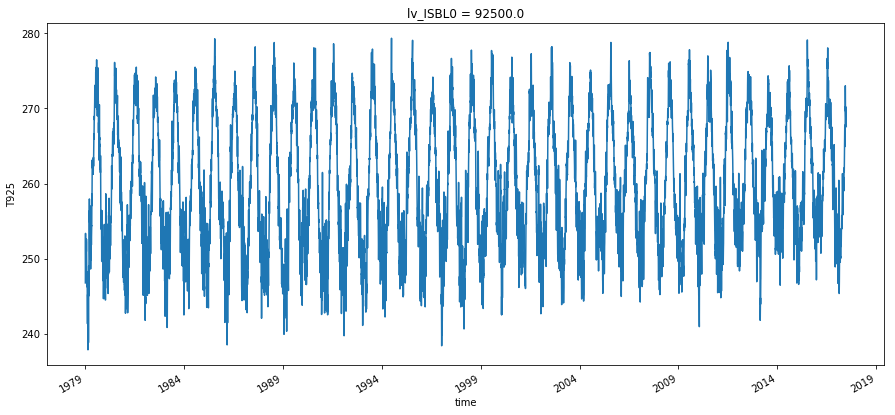

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(15,7))
ds['T925'].plot(ax=ax)

Organize data into DataFrame

In [7]:
# Create DateTimeIndex from time coordinate
time = pd.DatetimeIndex(ds['time'].values)

# Group by year and create dictionary of years
groups = ds['T925'].groupby('time.year').groups
tdict = {}
for grp in groups:
    tdict[grp] = pd.Series(ds['T925'][groups[grp]], index = time[groups[grp]].dayofyear)

# Put into DataFrame
df = pd.DataFrame(tdict)

# Convert to degrees celsius
df = df - 273.15

Plot data

In [19]:
def make_seasonal_temperature_plot(df, year_of_interest=None, title=None, other_years=None):
    
    import datetime as dt
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    if year_of_interest == None:
        year_of_interest = dt.datetime.today().year

    if title == None:
        title = '{:4d} Mean 925 hPa Air Temperature North of 80 $^\circ$N'.format(year_of_interest)
    
    start_doy=1
    legend_location=(0.5,0.35)
    add_axhline=True
    
    # Define list of years to calculate climatology
    climate_year = range(1980,2011)
    
    # Set x-axis ticks and label format
    months = mdates.MonthLocator()
    monthsFmt = mdates.DateFormatter('%b')
    
    # Set time values for x
    time = [dt.datetime.strptime('{:4d} {:3d}'.format(year_of_interest, start_doy),'%Y %j')+dt.timedelta(days=int(d)-1) for d in list(df.index)]
    
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    
    ax.fill_between(time, df[climate_year].min(1), df[climate_year].max(1), 
                     color='0.75', label='1980 to 2010 0-100th %')
    ax.fill_between(time, df[climate_year].quantile(0.15, axis=1), df[climate_year].quantile(0.85, axis=1), 
                     color='0.5', label='1980 to 2010 15-85th %')
    ax.fill_between(time, df[climate_year].quantile(0.3, axis=1), df[climate_year].quantile(0.7, axis=1), 
                     color='0.25', label='1980 to 2010 30-70th %')
    ax.plot(time, df[climate_year].median(1), color='k', linewidth=3, label='1980 to 2010 Median')
    
    ax.plot(time, df[year_of_interest], linewidth=3, color='r')
    
    if other_years != None:
        for thisYear in other_years:
            ax.plot(time, df[thisYear], linewidth=3, 
                    label='{:4d}'.format(thisYear))

    if add_axhline == True:
        ax.axhline(0., color='y', linestyle='--')
    
    ax.set_xlim(time[0], time[-1])
    ax.set_ylabel('Temperature ($^\circ$C)', fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    plt.legend(bbox_to_anchor=legend_location, loc=9, fontsize=15)

    return (fig, ax)

(<matplotlib.figure.Figure at 0x15d90a58>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15a160b8>)

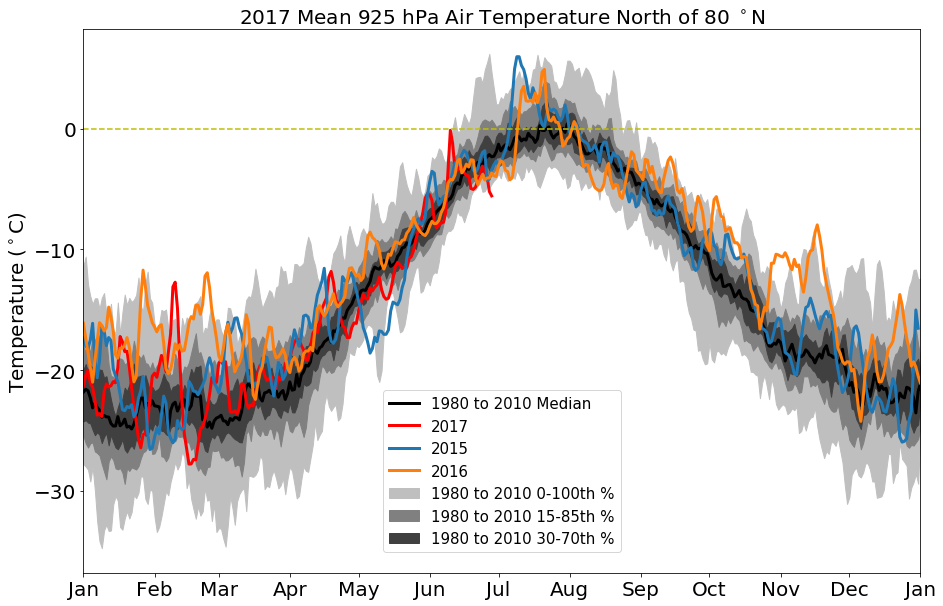

In [20]:
make_seasonal_temperature_plot(df, other_years=[2015,2016])

In [10]:
def make_seasonal_fdd_plot(df, year_of_interest=None, title=None):
  
    import numpy as np
    import datetime as dt
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    if year_of_interest == None:
        year_of_interest = dt.datetime.today().year

    if title == None:
        title = '{:4d} Cumulative Freezing Degree Days at 925 hPa North of 80 $^\circ$N'.format(year_of_interest)
    
    start_doy=182
    legend_location=(0.2,0.6)
    
    # Define list of years to calculate climatology
    climate_year = range(1980,2011)
    
    # Set x-axis ticks and label format
    months = mdates.MonthLocator()
    monthsFmt = mdates.DateFormatter('%b')
    
    # Set time values for x
    time = [dt.datetime.strptime('{:4d} {:3d}'.format(year_of_interest, start_doy),'%Y %j')+dt.timedelta(days=int(d)) for d in list(df.index)]
    
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    
    ax.fill_between(time, df[climate_year].min(1), df[climate_year].max(1), 
                     color='0.75', label='1980 to 2010 0-100th %')
    ax.fill_between(time, df[climate_year].quantile(0.15, axis=1), df[climate_year].quantile(0.85, axis=1), 
                     color='0.5', label='1980 to 2010 15-85th %')
    ax.fill_between(time, df[climate_year].quantile(0.3, axis=1), df[climate_year].quantile(0.7, axis=1), 
                     color='0.25', label='1980 to 2010 30-70th %')
    ax.plot(time, df[climate_year].median(1), color='k', linewidth=3, label='1980 to 2010 Median')
    
    ax.plot(time, df[year_of_interest], linewidth=3, color='r')
    
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(0, np.round(np.max(df_fdd.max()),-3))
    ax.set_ylabel('Total Freezing Degree Days ($^\circ$C)', fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    plt.legend(bbox_to_anchor=legend_location, loc=9, fontsize=15)

    return (fig, ax)

Calculate Freezing Degree Days and make plot

(<matplotlib.figure.Figure at 0xee2be10>,
 <matplotlib.axes._subplots.AxesSubplot at 0xee330f0>)

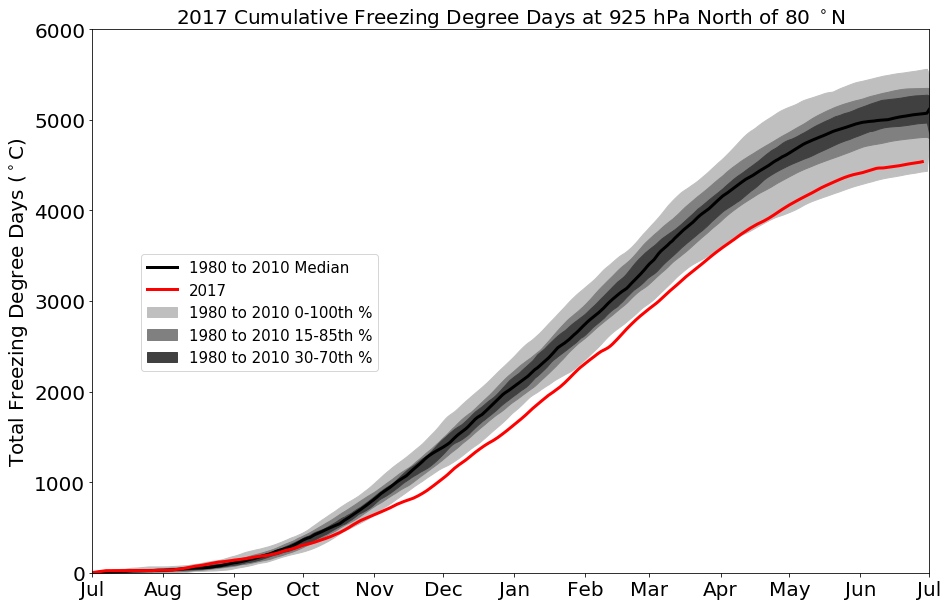

In [11]:
tdict = {}
tfrz  = 273.16
tthresh = -1.8 # Temperature threshold for Freezing Degree Days
for year in np.unique(pd.DatetimeIndex(ds['time'].values).year)[1:]:
    ts = pd.Series(ds['T925'].sel(time=slice('{:4d}-07-01'.format(year-1), '{:4d}-06-30'.format(year))))
    ts = (ts - tfrz) * -1.
    ts[ts < 0.] = 0.
    tdict[year] = ts.cumsum()
    
df_fdd = pd.DataFrame(tdict)

make_seasonal_fdd_plot(df_fdd, year_of_interest=2017)
#df_fdd.plot(ax=ax3)

Calculate anomalies of FDD

In [12]:
def make_seasonal_fdd_anom_plot(df, year_of_interest=None, title=None, other_years=None):
  
    import numpy as np
    import datetime as dt
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    
    if year_of_interest == None:
        year_of_interest = dt.datetime.today().year

    if title == None:
        title = '{:4d} Cumulative Freezing Degree Days Anomalies at 925 hPa North of 80 $^\circ$N'.format(year_of_interest)
    
    start_doy=182
    legend_location=(0.2,0.3)
    
    # Define list of years to calculate climatology
    climate_year = range(1980,2011)
    
    # Set x-axis ticks and label format
    months = mdates.MonthLocator()
    monthsFmt = mdates.DateFormatter('%b')
    
    # Set time values for x
    time = [dt.datetime.strptime('{:4d} {:3d}'.format(year_of_interest, start_doy),'%Y %j')+dt.timedelta(days=int(d)) for d in list(df.index)]
    
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    
    ax.fill_between(time, df[climate_year].min(1).rolling(7,win_type='boxcar').mean(), 
                    df[climate_year].max(1).rolling(7,win_type='boxcar').mean(), 
                     color='0.75', label='1980 to 2010 0-100th %')
    ax.fill_between(time, df[climate_year].quantile(0.15, axis=1).rolling(7,win_type='boxcar').mean(), 
                    df[climate_year].quantile(0.85, axis=1).rolling(7,win_type='boxcar').mean(), 
                     color='0.5', label='1980 to 2010 15-85th %')
    ax.fill_between(time, df[climate_year].quantile(0.3, axis=1).rolling(7,win_type='boxcar').mean(),
                    df[climate_year].quantile(0.7, axis=1).rolling(7,win_type='boxcar').mean(), 
                     color='0.25', label='1980 to 2010 30-70th %')
    #ax.plot(time, df[climate_year].median(1), color='k', linewidth=3, label='1980 to 2010 Median')
    ax.axhline(0, color='k', linewidth=3)
    
    ax.plot(time, df[year_of_interest].rolling(7,win_type='boxcar').mean(), linewidth=3, color='r', 
           label='{:4d} to {:4d}'.format(year_of_interest-1, year_of_interest))

    if other_years != None:
        for thisYear in other_years:
            ax.plot(time, df[thisYear].rolling(7,win_type='boxcar').mean(), linewidth=3, 
                    label='{:4d} to {:4d}'.format(thisYear-1, thisYear))
    
    ax.set_xlim(time[0], time[-1])
    #ax.set_ylim(0, np.round(np.max(df_fdd.max()),-3))
    ax.set_ylabel('Total Freezing Degree Days ($^\circ$C)', fontsize=20)
    ax.set_title(title, fontsize=20)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    plt.legend(bbox_to_anchor=legend_location, loc=9, fontsize=15)
    
    ax.text(0.5, 0.9, 'Colder', 
            color='b', fontsize=25, fontweight='bold', 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes)

    ax.text(0.5, 0.1, 'Warmer', 
            color='r', fontsize=25, fontweight='bold', 
            horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes)

    return (fig, ax)

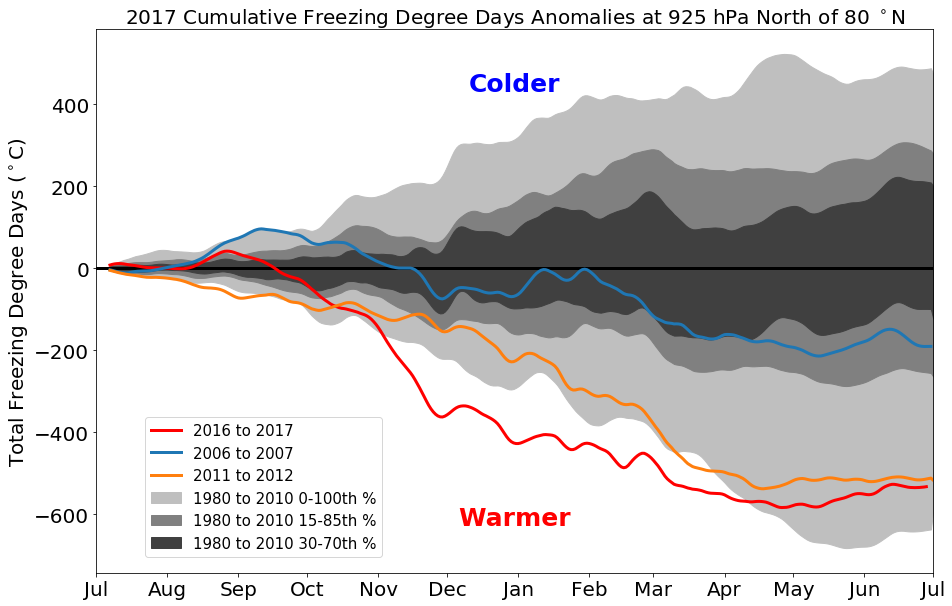

In [13]:
climate_year = range(1980,2011)
#df_fdd[climate_year].mean(axis=1)
df_fdd_anom = df_fdd[:].sub(df_fdd[climate_year].median(axis=1), axis=0)

fig, ax = make_seasonal_fdd_anom_plot(df_fdd_anom, year_of_interest=2017, other_years=[2007,2012])

fig.savefig(os.path.join(diri,'arctic_cum_fdd_anom_2017.png'), dpi=300)


372
366


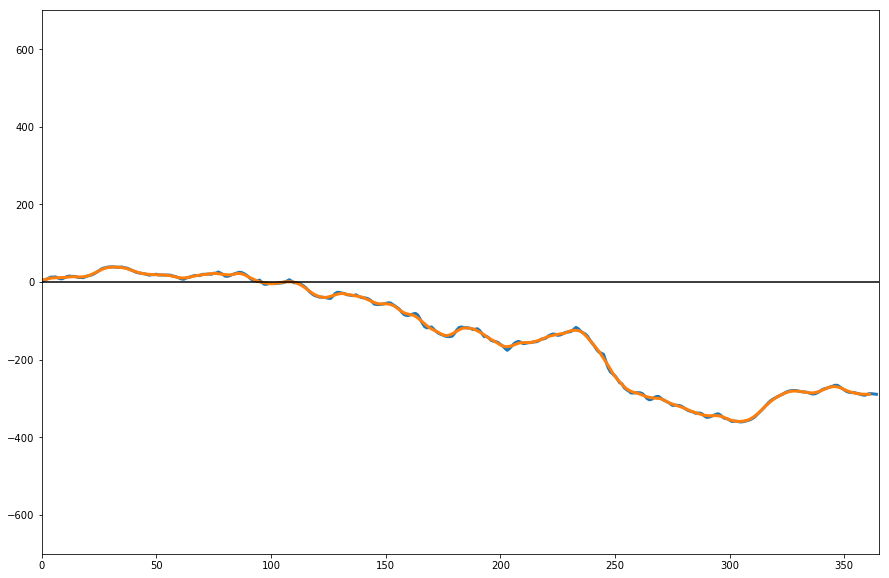

In [14]:
def moving_average(x, window_len=7):
    
    import numpy as np
    
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=numpy.ones(window_len,'d')
    y=numpy.convolve(w/w.sum(),s, mode='valid')
    return y

y = moving_average(df_fdd_anom[2015])
print len(y)
print len(df_fdd_anom[2015])

fig, ax = plt.subplots(figsize=(15,10))

df_fdd_anom[2015].plot(ax=ax, linewidth=3)
#df_fdd_anom[2015].rolling(7,win_type='boxcar', center=True).mean().plot(ax=ax, linewidth=3)
ax.plot(moving_average(df_fdd_anom[2015])[3:], linewidth=3)
ax.set_ylim(-700,700)
ax.axhline(0., color='k')